In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
# import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from time import time, strptime, mktime
torch.manual_seed(0)
np.random.seed(0)

In [5]:
from glob import glob
from utils import *

# 200176-905003
# 402143-402145
st, ed = '402143', '402145'
# st, ed = '402694', '403434'
segstr = '\n'.join([st, ed])
matches = []
sfiles = glob('data/stopcodes_sequence/*.txt')
for sname in sfiles:
    with open(sname) as fl:
        raw = fl.read()
    if segstr in raw:
        matches.append(fileName(sname).split('_')[0])
print(matches)

['BM1', 'BM3', 'BM4', 'X5', 'X38', 'X37', 'BM2', 'X2']


In [13]:
mtafiles = sorted(glob('/home/ubuntu/datasets-aux/mta/*.txt'))
print(len(mtafiles))
print(mtafiles[0])

90
/home/ubuntu/datasets-aux/mta/MTA-Bus-Time_.2014-08-01.txt


In [14]:
from utils import *

for fii, fname in tqdm(enumerate(mtafiles)):
    ftag = fname.split('.')[1]
    raw_seghist = []
    with open(fname) as fl:
        _ = fl.readline()
        line = fl.readline()
        while line:
            if 'NULL' not in line and 'IN_PROGRESS' in line:
                if any([bid in line for bid in matches]):
    #                 if any([sid in line for sid in [st, ed]]):
                    try:
                        raw_seghist.append(fmt(line))
                    except:
                        print(line)
                        assert False
            line = fl.readline()
            
    seghist = list(filter(lambda obj: obj['direction'] == 0, raw_seghist))
    seghist = list(filter(lambda obj: obj['phase'], seghist))
    
    bybus = group(seghist, 'busid')

    useable = []
    useable_post = []
    PLOT=False
    # for ii, (bid, travel) in enumerate(list(bybus.items())[:50]):
    for ii, (bid, travel) in enumerate(bybus.items()):
        inseg = [(mktime(ent['time']), ent['dist']) for ent in travel if ed in ent['stop']]
        if len(inseg) == 0:
            continue
        segs = find_segs(travel)

        tlast = None    
        for si, seg in enumerate(segs):
            if len(seg) <= 1:
                continue
            if len(seg) < 40: continue
            vs = est_velocity(seg)
            vs = strip_seg(vs, prop='vel')
            if len(vs) < 30: continue
            useable.append(lscopy(vs))

            velocity = np.array([obj['vel'] for obj in vs])
            ts = np.array([mktime(ent['time']) for ent in vs])
            if tlast is not None: ts -= (ts[0] - tlast)
            tlast = ts[-1]


            _ = np.array([obj['vel'] for obj in remove_stops(vs)])
            vs, rmd = remove_peaks(vs, maxv=60)
            if rmd > 3: # fix max 3 peaks.. otherwise unreliable bus
                continue

            msize=5
            mhalf = int(msize//2)
            mean_vs = smooth_mean(lscopy(vs), fsize=msize)

            ssize=5
            shalf = int(ssize//2)
            skewed_vs = smooth_skewed(lscopy(vs), fsize=ssize, expval=1.1)

            rsize=5
            rhalf = int(rsize//2)
            range_vs = smooth_range(lscopy(vs), fsize=rsize)

    #         velocity = np.array([obj['vel'] for obj in vs])
            useable_post.append([mean_vs, skewed_vs, range_vs])
    #     break
    
#         sys.stdout.write('[%d/%d]: %d/%d    \r' % (fii, len(mtafiles), ii, len(bybus)))
#     sys.stdout.flush()
    
    if not len(useable_post):
        continue
        
    mvs, svs, rvs = zip(*useable_post)
    m5, m10 = bucket_segs(rvs, st, ed, tints=[5, 10])
    
    droot = '/home/ubuntu/datasets-aux/mta/parsed'
    import json
    with open('%s/r05_%s.json' % (droot, ftag), 'w') as fl:
        json.dump(m5, fl, indent=4)
    with open('%s/r10_%s.json' % (droot, ftag), 'w') as fl:
        json.dump(m10, fl, indent=4)
#     break

1it [00:40, 40.32s/it]


ValueError: not enough values to unpack (expected 3, got 0)

In [36]:
r10files = sorted(glob('%s/r10*.json' % (droot)))
r5files = sorted(glob('%s/r05*.json' % (droot)))
print(len(rfiles))
print(rfiles[0])

63
/home/ubuntu/datasets-aux/mta/parsed/r10_2014-08-01.json


In [38]:
raw = []
for r10, r5 in zip(r10files, r5files):
    with open(r10) as fl10:
        with open(r5) as fl5:
            raw.append((rname, [json.load(fl10), json.load(fl5)]))
print(len(raw))
# print(raw[0])

63


In [43]:
with open('%s/%s/%s/%s-%s.csv' % (DPATH, SPEEDS, st[0], st, ed)) as fl:
    lines = fl.read().split('\n')[1:-1]
lines = [ent.split(',') for ent in lines]
olddata = [(datetime.strptime(ent[0], '%Y-%m-%d %H:%M:%S'), ent[1]) for ent in lines]
olddata = [(mktime(ent[0].timetuple()), float(ent[1])) for ent in olddata if ent[1] is not '']
print(len(olddata))

1674


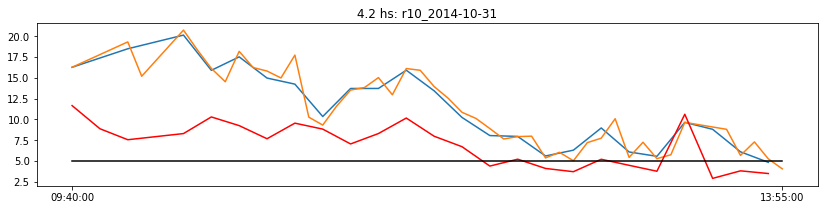

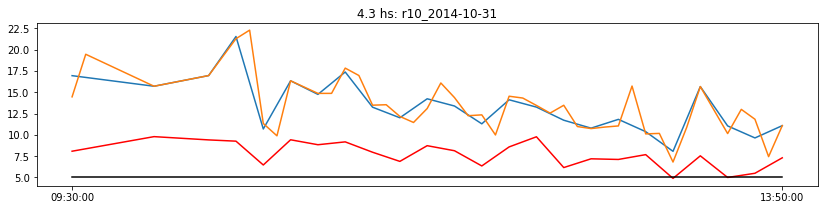

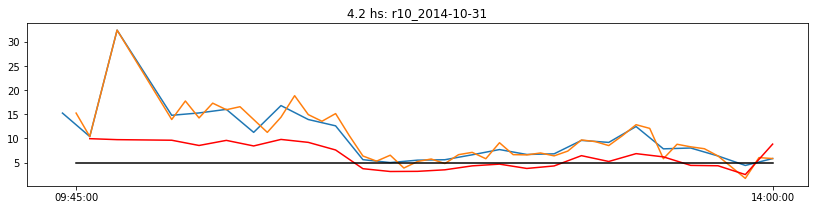

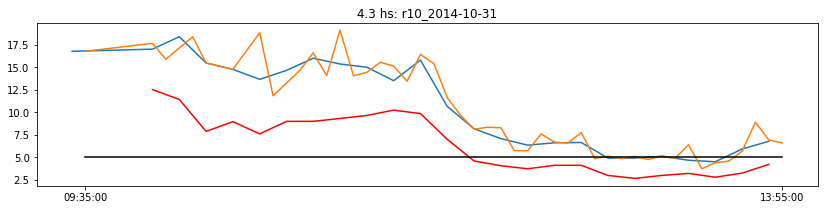

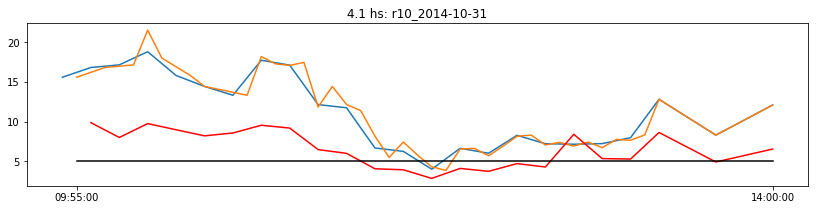

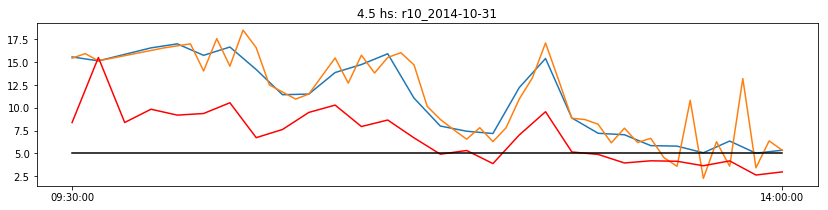

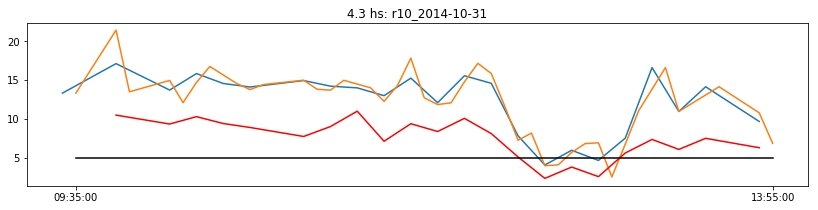

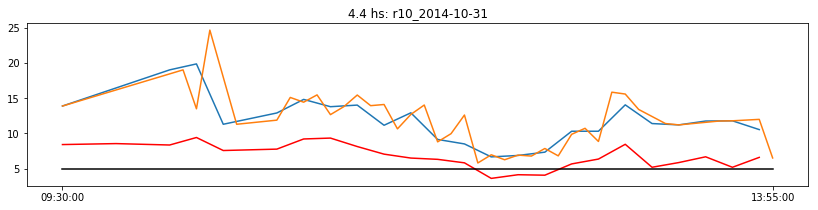

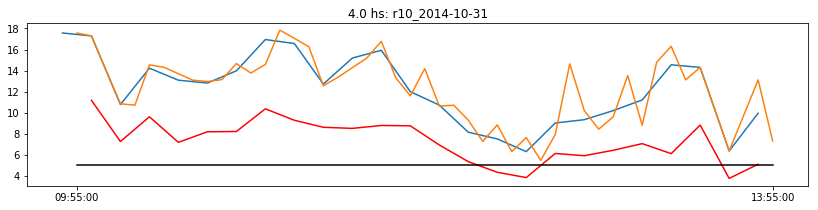

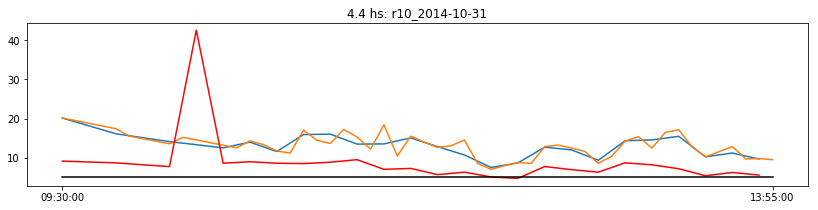

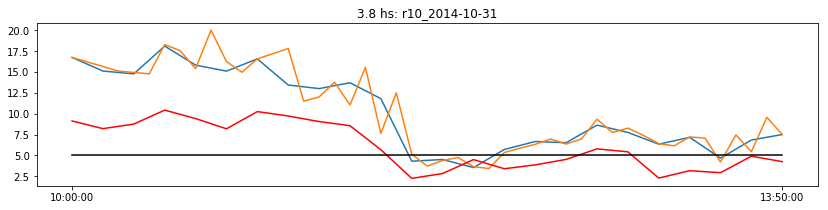

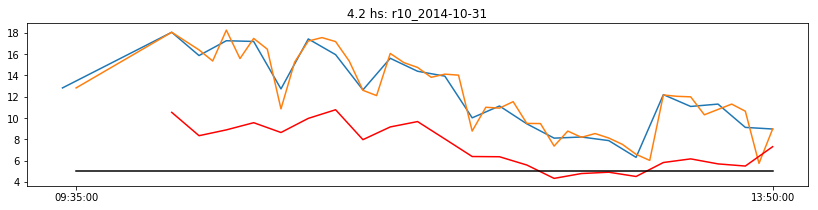

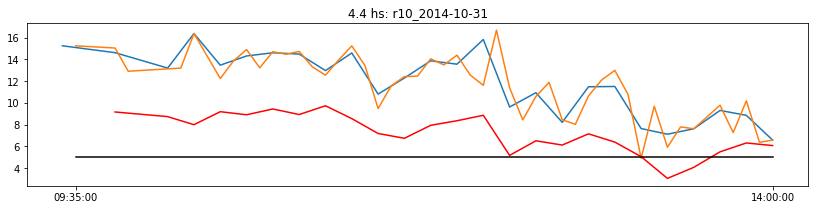

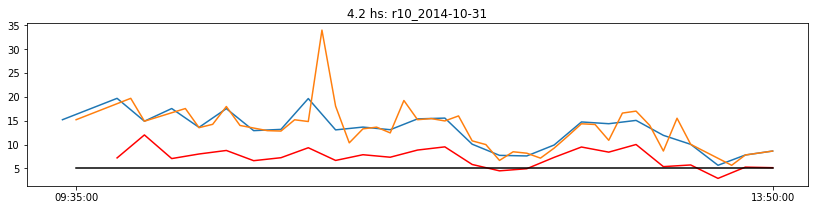

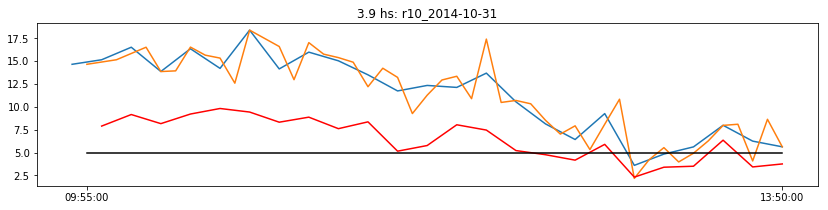

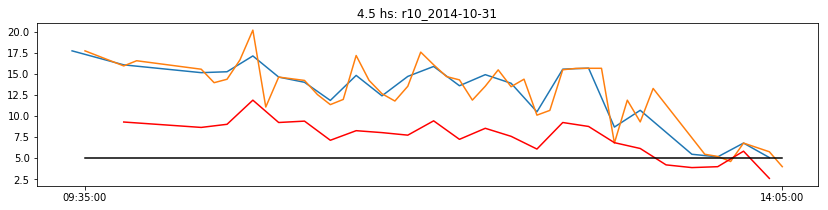

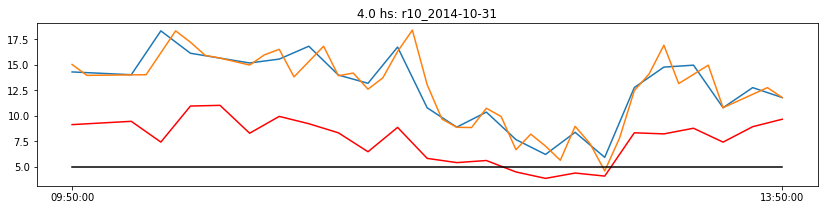

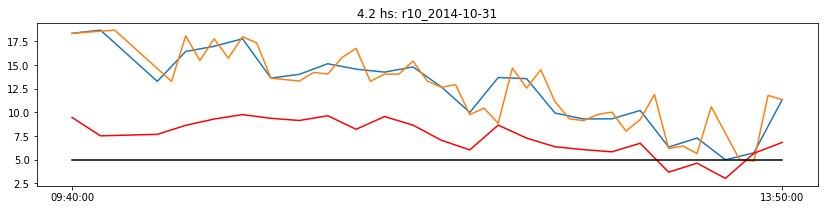

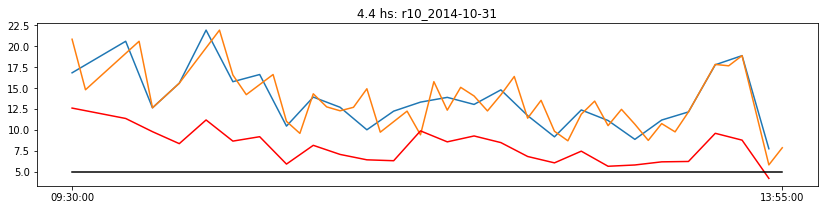

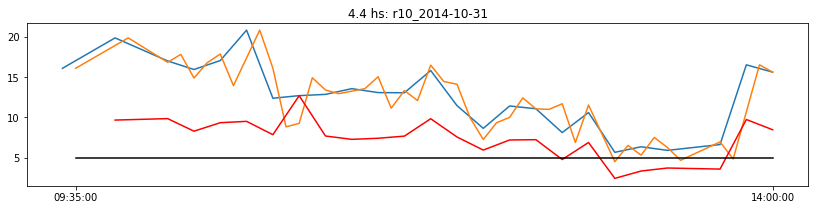

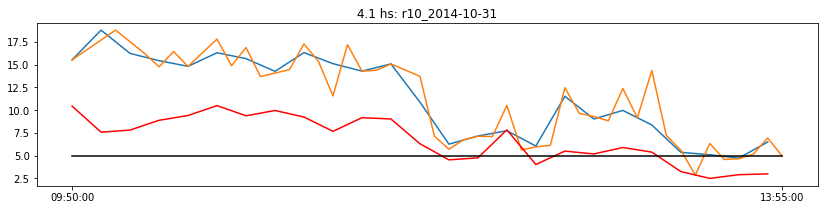

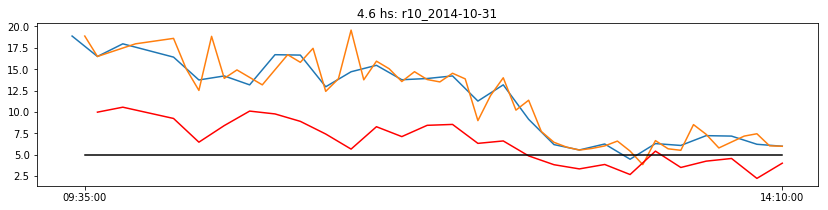

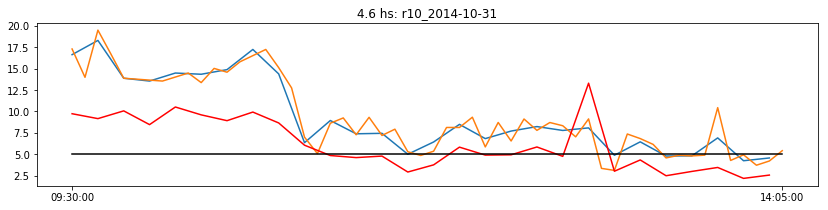

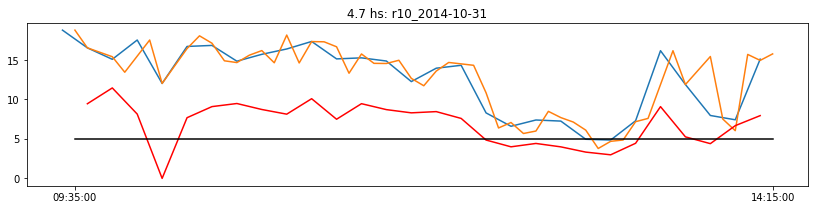

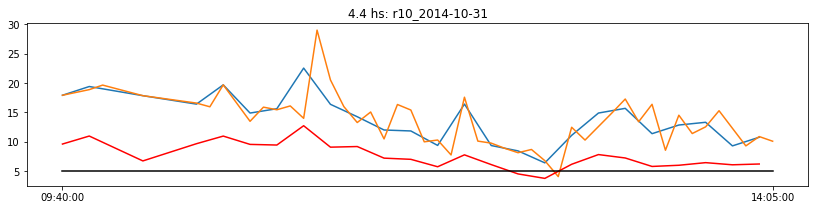

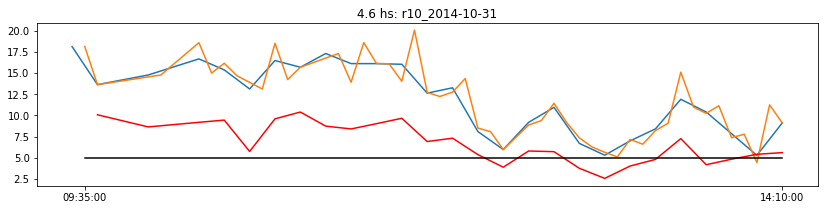

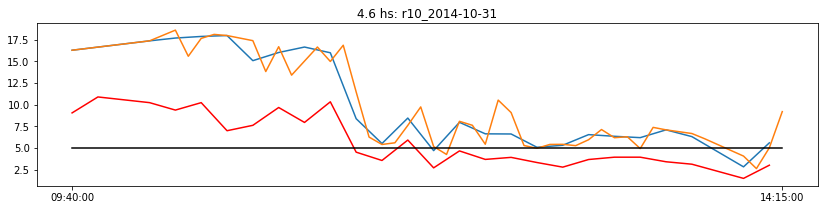

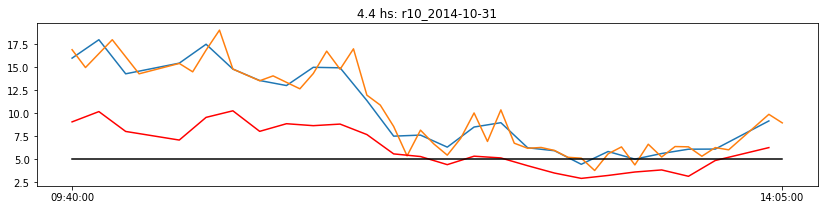

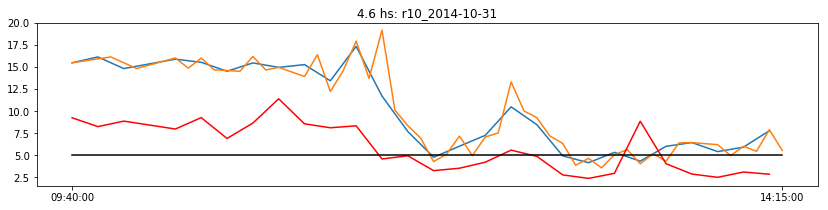

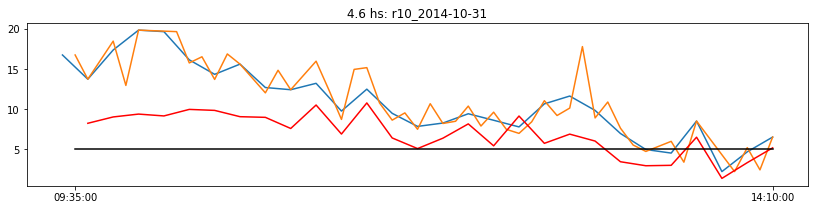

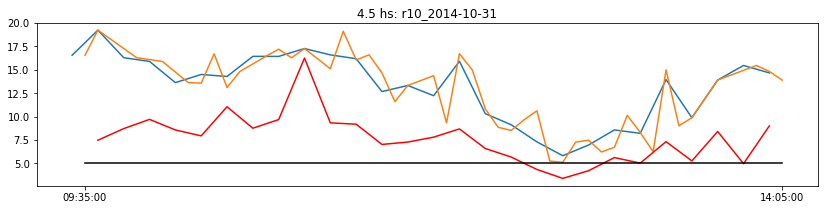

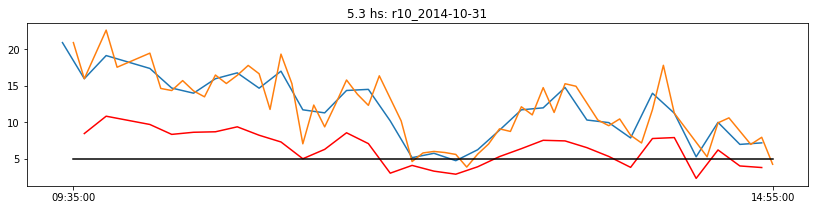

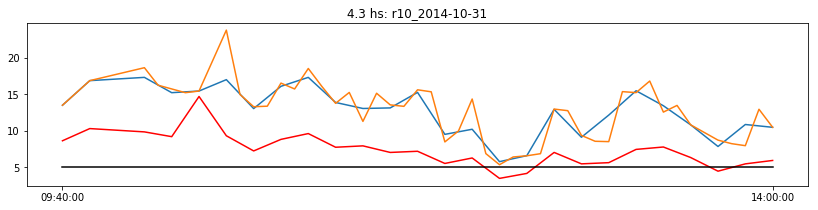

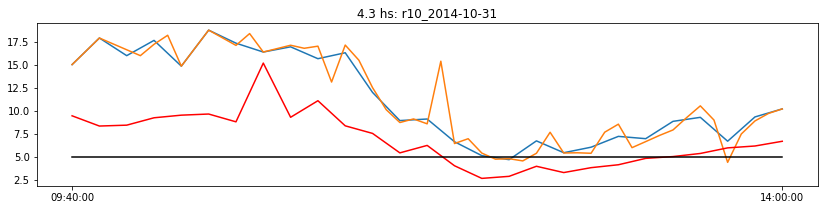

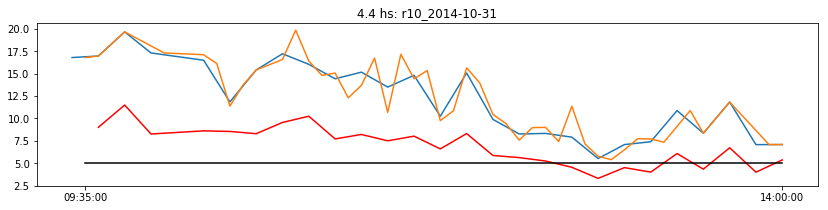

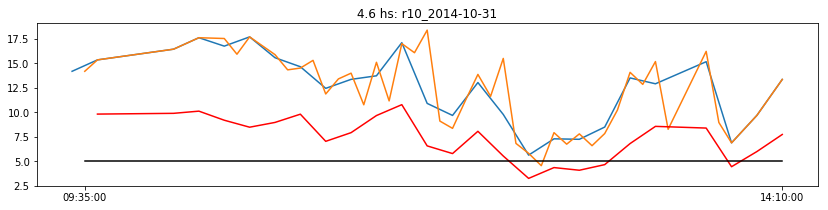

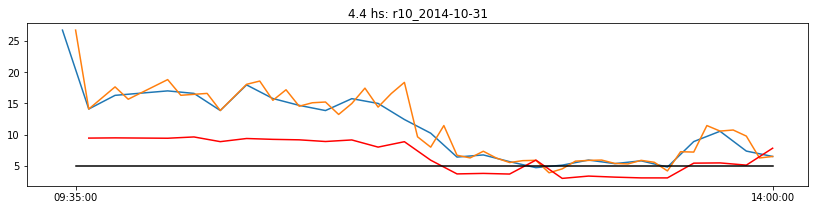

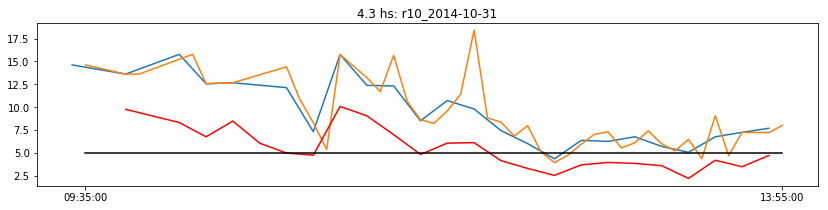

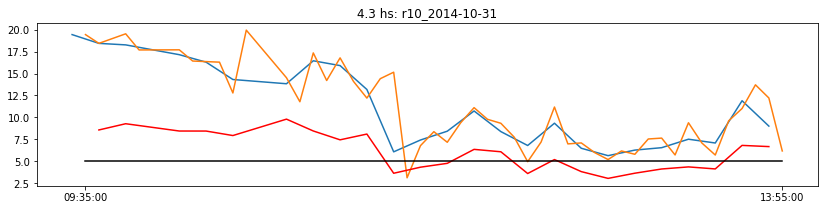

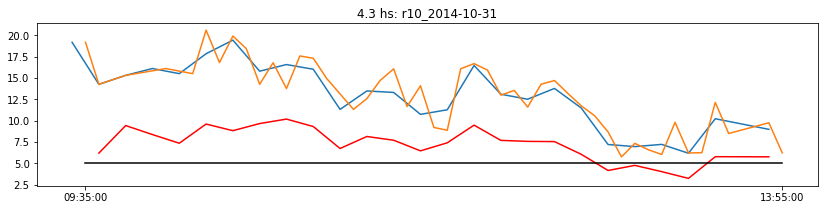

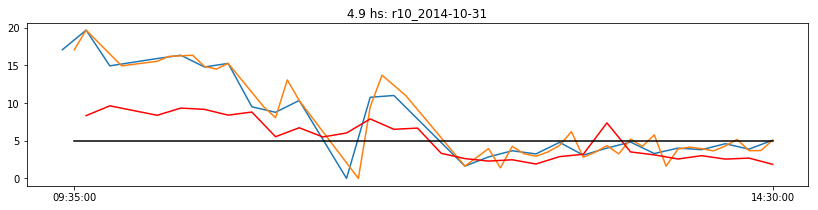

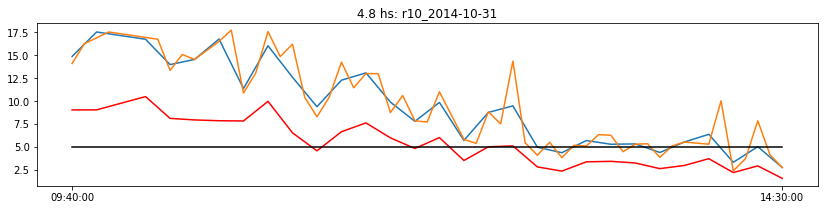

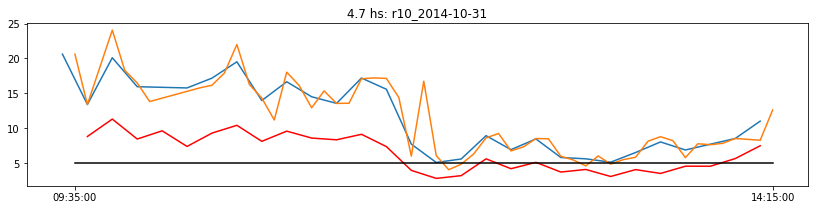

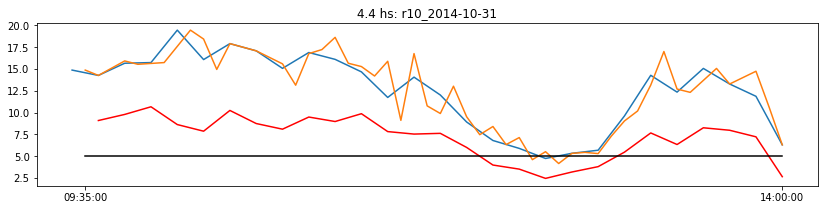

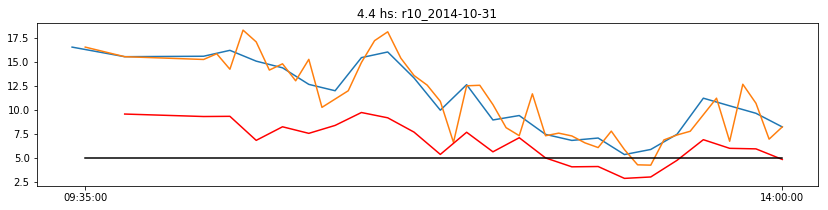

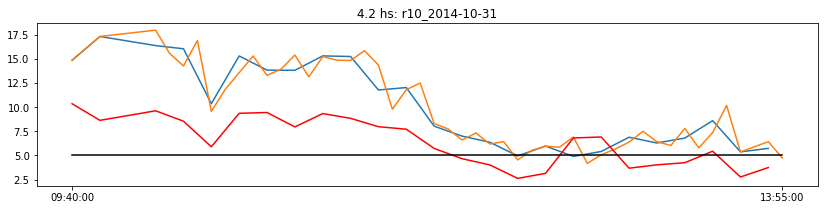

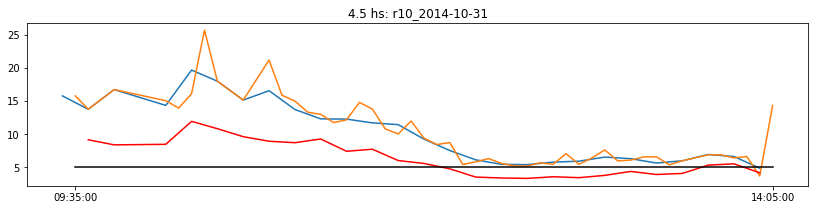

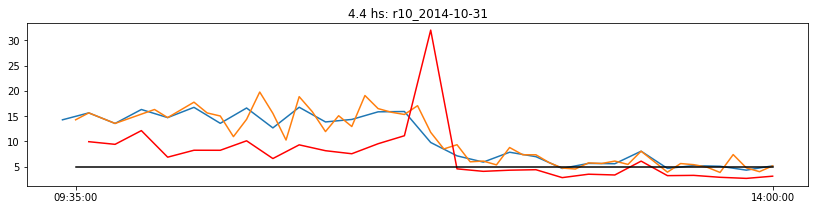

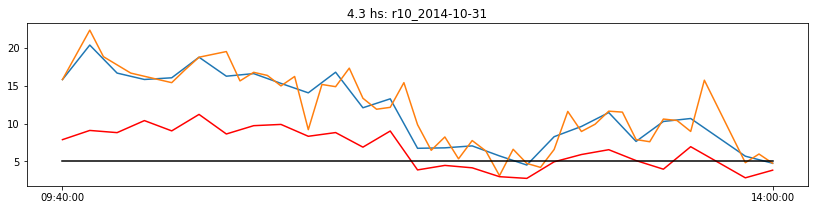

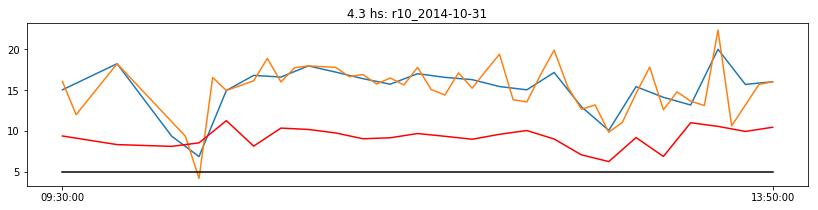

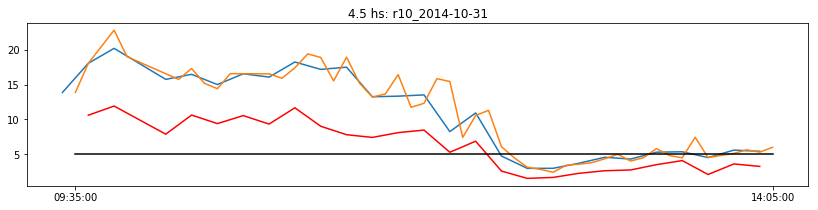

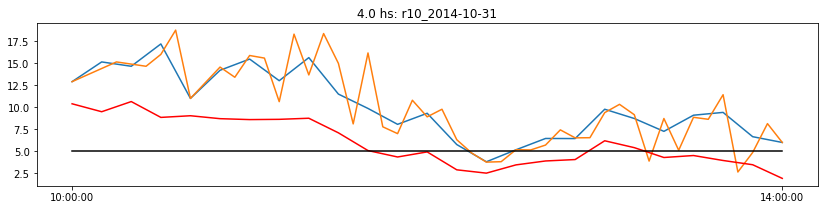

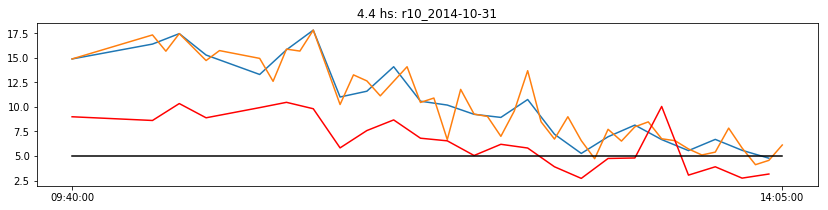

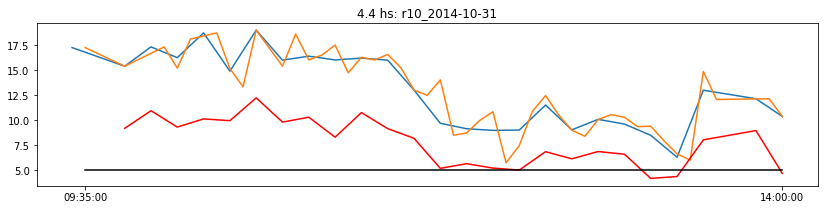

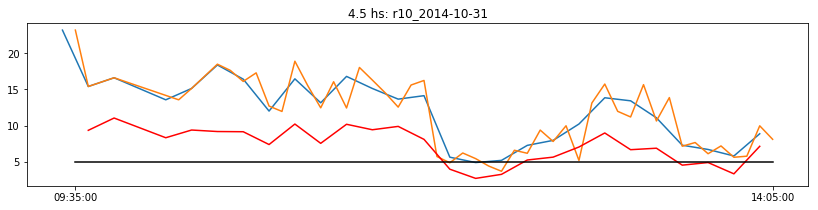

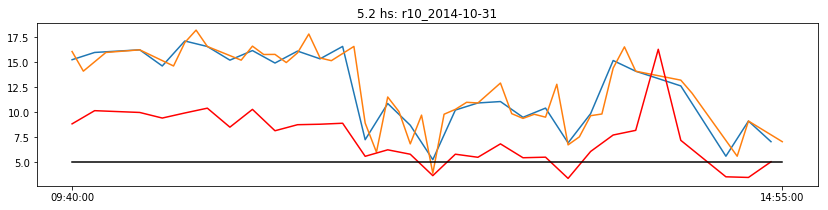

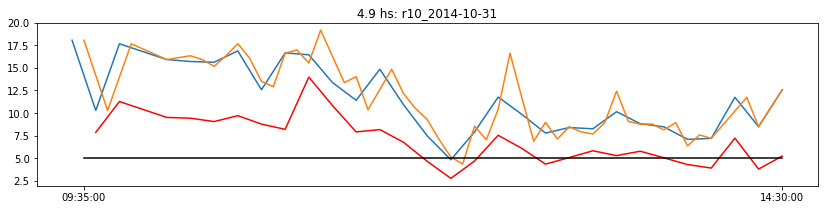

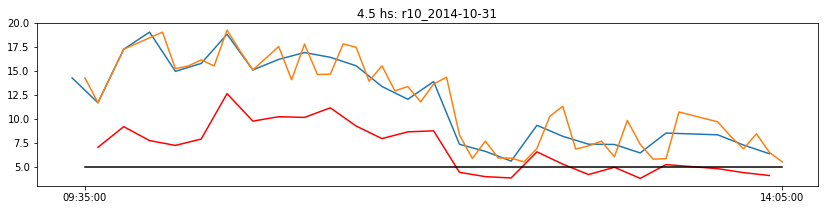

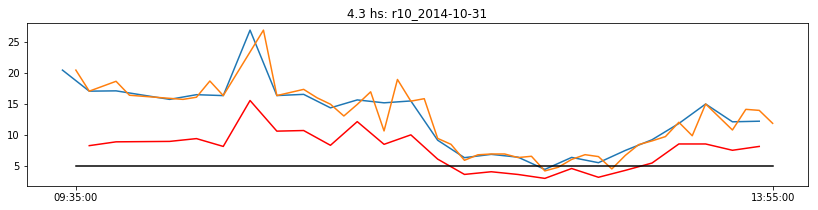

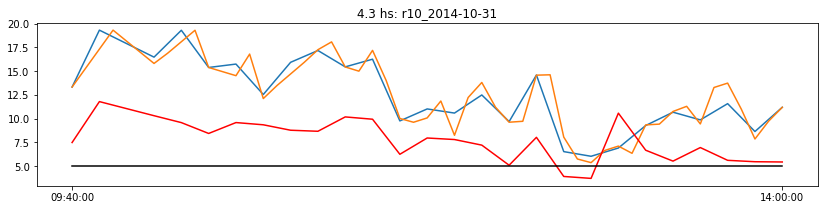

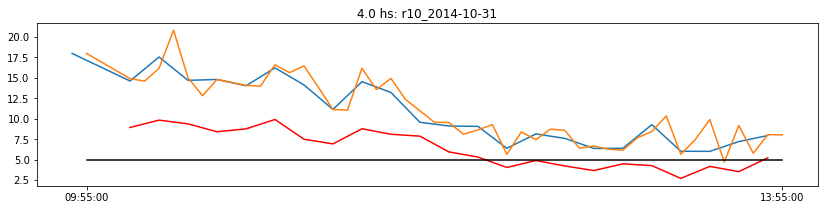

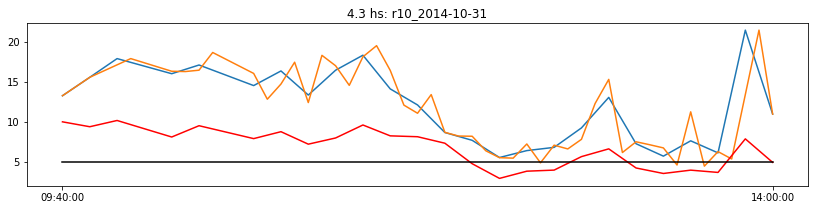

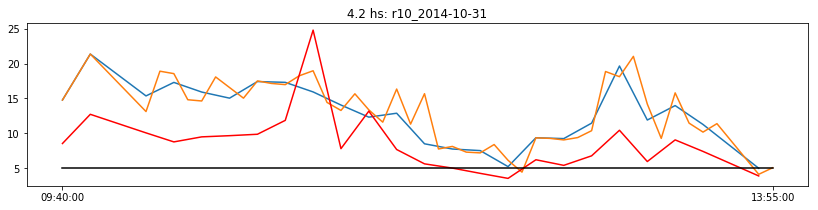

In [45]:
from utils import *
for rname, series in raw:
    plt.figure(figsize=(14, 3))
    for resolution in series:
        ts, vs = zip(*[(ent['time'], ent['vel']) for ent in resolution])
        plt.plot(ts, vs)
        
    oldInRange = [ent for ent in olddata if ent[0] >= ts[0] and ent[0] <= ts[-1]]
    ots, ovs = zip(*oldInRange)
    plt.plot(ots, np.array(ovs) * MMPH, color='red')
#     plots.append(pp[0])
        
    plt.xticks([ts[0], ts[-1]], [shm(ts[0]), shm(ts[-1])])
    plt.plot([ts[0], ts[-1]], [5, 5], color='black')
    dh = (ts[-1] - ts[0]) / (60 * 60)
    plt.title('%.1f hs: %s' % (dh, fileName(rname)))
    plt.show(); plt.close()
#     break

In [52]:
below6 = 0
for rname, series in raw:
    mv = min([ent['vel'] for ent in series[0]])
    if mv < 6:
        below6 += 1
print(below6, len(raw))

50 63
